# Power vs. Dimension for 14 Relationships - Supplement

In [1]:
import glob
import math
import os, sys
import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed, dump, load
from matplotlib.legend import Legend
from matplotlib.ticker import ScalarFormatter
from scipy.stats import entropy, norm, mstats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

from hyppo.independence import Dcorr
from hyppo.ksample import k_sample_transform
from sktree.ensemble import HonestForestClassifier
from sktree.stats import FeatureImportanceForestClassifier

from simulations import *

sys.path.append(os.path.realpath('..'))

In [2]:
def calibrator(tree, X, y, test_size=0.2):
    indices = np.arange(X.shape[0])
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
        X, y, indices, test_size=test_size
    )

    tree.fit(X_train, y_train)
    y_pred = tree.predict_proba(X_test)[:, 1]

    # Fill test set posteriors & set rest NaN
    posterior = np.full(y.shape, np.nan)
    posterior[indices_test] = y_pred

    return posterior


def forest_pos(posterior, y):
    # Average all posteriors
    posterior_final = np.nanmean(posterior, axis=0)

    # Ignore all NaN values (samples not tested)
    true_final = y.ravel()[~np.isnan(posterior_final)].reshape(-1, 1)
    posterior_final = posterior_final[~np.isnan(posterior_final)].reshape(-1, 1)

    return np.hstack((true_final, posterior_final))


class MIGHT:
    def __init__(
        self,
        n_estimators=500,
        bootstrap=False,
        limit=0.05,
        **kwargs
    ):
        self.clf = HonestForestClassifier(
            n_estimators=n_estimators,
            bootstrap=bootstrap,
            **kwargs
        )
        self.limit = limit

    def statistic(
        self,
        x,
        y,
        workers=1,
        test_size=0.2,
        initial=True,
    ):
         # estimate posteriors
        self.clf.fit(x, y.ravel())
        posterior = self.clf.predict_proba(x)

        # compute mutual information
        H_YX = np.mean(entropy(posterior, base=np.exp(1), axis=1))
        _, counts = np.unique(y, return_counts=True)
        H_Y = entropy(counts, base=np.exp(1))
        stat = max(H_Y - H_YX, 0)

        return stat

In [3]:
class Dcorr_PCA:
    def test(self, x, y):
        n_components = int(np.sqrt(x.shape[0]))
        x_pca = PCA(n_components=n_components).fit_transform(x)
        return Dcorr().test(x_pca, y)

In [4]:
def _indep_sim_gen(sim, n, p, noise=True):
    """
    Generate x, y from each sim
    """
    kwargs = {}
    if sim != "multimodal_independence":
        kwargs = {"noise" : noise}

    return indep_sim(sim, n, p, **kwargs)


def _perm_stat(est, sim, n=100, p=1, noise=True, **kwargs):
    """
    Generates null and alternate distributions
    """
    x, y = _indep_sim_gen(sim, n, p, noise=noise)
    u, v = k_sample_transform([x, y])
    obs_stat = est.statistic(u, v, **kwargs)
    permv = np.random.permutation(v)
    perm_stat = est.statistic(u, permv, **kwargs)

    return obs_stat, perm_stat


def _nonperm_pval(est, sim, n=100, p=1, noise=True, **kwargs):
    """
    Generates fast  permutation pvalues
    """
    x, y = _indep_sim_gen(sim, n, p, noise=noise)
    u, v = k_sample_transform([x, y])
    pvalue = est.test(u, v, **kwargs)[1]

    return pvalue

In [5]:
sns.set_theme(color_codes=True, style='ticks', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[2:5] + PALETTE[6:], n_colors=9)

# SAMP_SIZES = [1024]
DIMENSIONS = [2**i for i in range(5, 13)]
SAMP_SIZE = 512
REPS = range(100, 1000)

SAVE_PATH = "n-{}_p-{}_{}".format(int(SAMP_SIZE), int(DIMENSIONS[0]), int(DIMENSIONS[-1]))
FIG_PATH = "figs"

SIMULATIONS = {
    "linear": "Linear",
    "exponential": "Exponential",
    "cubic": "Cubic",
    "step": "Step",
    "quadratic": "Quadratic",
    "w_shaped": "W-Shaped",
    "logarithmic": "Logarithmic",
    "fourth_root": "Fourth Root",
    "sin_four_pi": "Sine 4\u03C0",
    "sin_sixteen_pi": "Sine 16\u03C0",
    "square": "Square",
    "two_parabolas": "Two Parabolas",
    "diamond": "Diamond",
    "multimodal_independence": "Independence",
}

TESTS = {
    "Dcorr" : Dcorr(),
    "Dcorr_PCA" : Dcorr_PCA(),
    "MIGHT" : MIGHT(),
    # "MIGHT-sktree" : FeatureImportanceForestClassifier(
    #             estimator=HonestForestClassifier(n_estimators=500, max_features=1.0, n_jobs=1),
    #             test_size=0.2,
    #             permute_per_tree=False,
    #             sample_dataset_per_tree=False
    #         ),
    # "MIGHT-Coleman" : FeatureImportanceForestClassifier(
    #             estimator=HonestForestClassifier(n_estimators=500, max_features=1.0, n_jobs=1),
    #             test_size=0.2,
    #             permute_per_tree=False,
    #             sample_dataset_per_tree=False
    #         ),
    # "MIGHT-PermTree" : FeatureImportanceForestClassifier(
    #             estimator=HonestForestClassifier(n_estimators=500, max_features=1.0, n_jobs=1),
    #             test_size=0.2,
    #             permute_per_tree=True,
    #             sample_dataset_per_tree=False
    #         ),
}

In [6]:
def compute_null(rep, est, est_name, sim, n=100, p=1, noise=True):
    """
    Calculates empirical null and alternate distribution for each test.
    """
    kwargs = {}
    if est_name in ["MIGHT-sktree", "MIGHT-Coleman"]:
        kwargs = {"metric" : "mi"}
    if est_name in ["MIGHT", "MIGHT-sktree"]:
        alt_dist, null_dist = _perm_stat(est, sim, n, p, noise=noise, **kwargs)
        np.savetxt("{}/{}_{}_{}_{}.txt".format(SAVE_PATH, sim, est_name, n, rep), [alt_dist, null_dist], delimiter=",")
    else:
        pval = _nonperm_pval(est, sim, n, p, noise=noise, **kwargs)
        np.savetxt("{}/{}_{}_{}_{}.txt".format(SAVE_PATH, sim, est_name, n, rep), [pval])

In [7]:
# Run this block to regenerate power curves. Note that this takes a very long time!

# _ = Parallel(n_jobs=-1, verbose=100)(
#     [
#         delayed(compute_null)(rep, est, est_name, sim, n=SAMP_SIZE, p=dim, noise=True)
#         for rep in REPS
#         for est_name, est in TESTS.items()
#         for sim in SIMULATIONS.keys()
#         for dim in DIMENSIONS
#     ]
# )

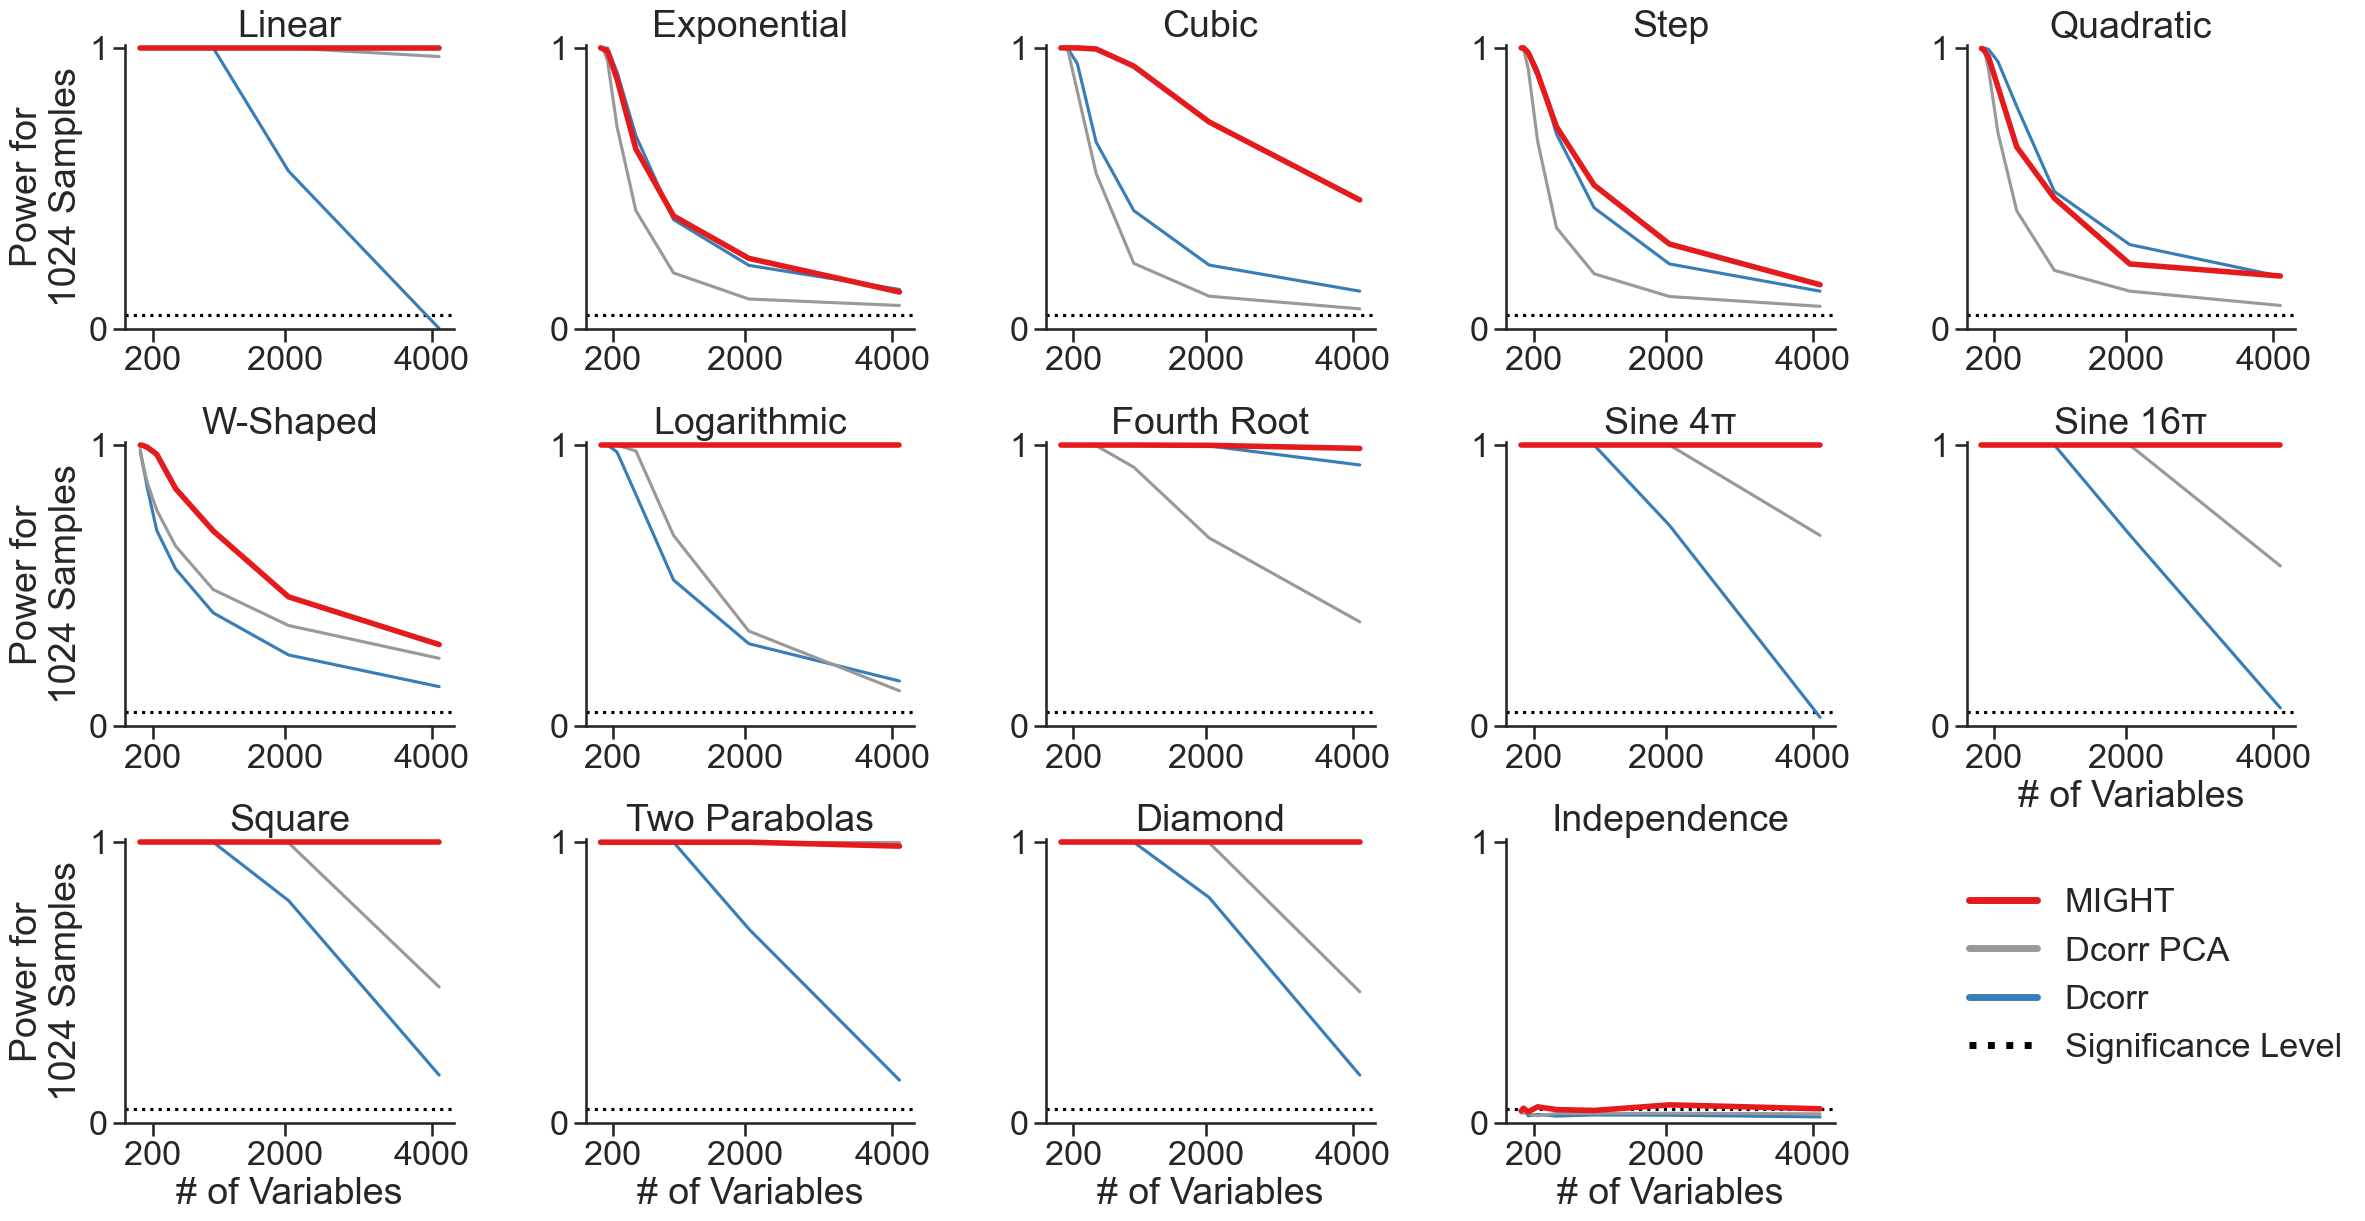

In [14]:
ALPHA = 0.05
FIG_REPS = 1000
NROWS, NCOLS = 3, 5
PLOT_KWARGS = {
    "Dcorr" : {"color" : "#377eb8"},
    "Dcorr_PCA" : {"color" : "#999999"},
    "MIGHT" : {"color" : "#e41a1c", "lw" : 4},
    "MIGHT-sktree" : {"color" : "#e41a1c", "lw" : 4, "linestyle" : "--"},
    "MIGHT-Coleman" : {"color" : "#e41a1c", "lw" : 4, "linestyle" : ":"},
}

fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(28, 14))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        count = NCOLS * i + j

        if count != 14:
            col.axhline(y=0.05, linestyle=":", color="#000000", label="Significance Level")
            for test_key in list(TESTS.keys()):
                test_name = test_key.replace("_", " ")
    
                sim_name = list(SIMULATIONS.keys())[count]
    
                title = SIMULATIONS[sim_name]
                power = []
                for dim in DIMENSIONS:
                    file_name = "{}/{}_{}_{}".format(SAVE_PATH, sim_name, test_key, dim)
                    if test_key in ["MIGHT", "MIGHT-sktree"]:
                        alt_dist, null_dist = map(
                            np.float64,
                            zip(*[
                                np.genfromtxt("{}_{}.txt".format(file_name, rep))
                                for rep in range(FIG_REPS)
                            ]),
                        )
                        cutoff = np.sort(null_dist)[math.ceil(FIG_REPS * (1 - ALPHA)) - 1]
                        empirical_power = (1 + (alt_dist >= cutoff).sum()) / (1 + FIG_REPS)
                    else:
                        pvals = np.array([
                            np.genfromtxt("{}_{}.txt".format(file_name, rep))
                            for rep in range(FIG_REPS)
                        ])
                        empirical_power = (1 + (pvals <= ALPHA).sum()) / (1 + FIG_REPS)
                    power.append(empirical_power)
                
                # print(power)
                col.plot(DIMENSIONS, power, label=test_name, **PLOT_KWARGS[test_key])
            col.set_ylim(0, 1.01)
            col.set_yticks([])
            col.set_xticks([])
            col.set_yticks([0, 1])
            col.set_xticks([200, 2000, 4000])
            if j == 0:
                col.set_ylabel("Power for\n1024 Samples")
            if i == NROWS - 1:
                col.set_xlabel("# of Variables")
            if i == NROWS - 2 and j == NCOLS - 1:
                col.set_xlabel("# of Variables")
            col.set_title(title)
            sns.despine(right=True)
        else:
            col.set_axis_off()

leg = row[0].legend(
    bbox_to_anchor=(0.85, 0.3),
    bbox_transform=plt.gcf().transFigure,
    ncol=1,
    loc="upper center",
    reverse=True
)
leg.get_frame().set_linewidth(0.0)
for legobj in leg.legend_handles:
        legobj.set_linewidth(5.0)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.savefig(FIG_PATH + '/all_power_dimension.svg', transparent=True, bbox_inches='tight')